# Figure 10

Load librairies

In [1]:
import numpy as np                  # Data
import pandas as pd                 # Data
import matplotlib.pyplot as plt     # Plot
import matplotlib.lines as mlines   # Plot

Use Latex Font

In [2]:
""" plt.rcParams.update({"text.usetex": True,
                     "font.family": "serif",
                     "font.serif": ["Computer Modern"],
                     "font.size": 11,
                     "axes.labelsize": 11,
                     "legend.fontsize": 11,
                     "xtick.labelsize": 9,
                     "ytick.labelsize": 9})   """

' plt.rcParams.update({"text.usetex": True,\n                     "font.family": "serif",\n                     "font.serif": ["Computer Modern"],\n                     "font.size": 11,\n                     "axes.labelsize": 11,\n                     "legend.fontsize": 11,\n                     "xtick.labelsize": 9,\n                     "ytick.labelsize": 9})   '

# Data & Methodology

Read capacity factor analysis data from 1979 to 2023

In [3]:
df_combine = pd.read_csv('../Data/cf_analysis_1979-2023.csv',
                         index_col = 0,
                         parse_dates = True)

Create moving average

In [4]:
df_combine_avg = df_combine.rolling('D', min_periods = 24, center = True).mean()

Function to identify a RES drought.
 - Select only the values below the selected threshold
 - Group consecutive True/False values and count consecutive hours below threshold
 - Find the end of each drought event
 - Adjust the index to point to the start time of each drought event

In [5]:
def identify_drought(time_series: pd.Series,threshold:float):
    events_thresh = time_series < threshold
    raw_events = events_thresh.groupby(events_thresh.ne(events_thresh.shift()).cumsum()).cumsum()
    identified_events = raw_events[(raw_events.shift(1) < raw_events) & (raw_events.shift(-1) < raw_events)]
    identified_events.index = pd.Index([date - pd.Timedelta(identified_events.loc[date] - 1, unit = 'h') for date in identified_events.index])
    return identified_events

Repeat the function *identify_droughts* for all time series from the *df_combine_avg* data frame.

The events for one series are stored in a pandas DataFrame and those series are stored in a dictonary *droughts_dict*.

In [6]:
droughts_dict = {}

for column in df_combine_avg:
    raw_droughts = identify_drought(df_combine_avg[column], 0.10)
    droughts = raw_droughts[raw_droughts > 24]
    droughts_df = pd.DataFrame(droughts)
    droughts_df = droughts_df.set_axis(['Duration'], axis = 1)
    droughts_dict[column] = droughts_df

Create new data frame *df_flags* which has the same shape as df_combine_avg, but flags events using the dictonary *droughts_dict*

In [7]:
df_flags = pd.DataFrame(0, index = df_combine_avg.index, columns = df_combine_avg.columns)

for col, droughts_df in droughts_dict.items():
    for start_time, duration in droughts_df['Duration'].items():
        end_time = start_time + pd.Timedelta(hours = duration)
        df_flags.loc[start_time:end_time, col] = 1

## Plot

In [8]:
months = np.arange(12)
dim = np.array([31, 28.25, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
month_labels = ['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']

label_name = ['ATL', 'C3S GRD', 'C3S NAT']
title_name = ['a) Wind Only ', 'b) PV Only', 'c) 91\% Wind / 9\% PV', 'd) 57\% Wind / 43\% PV']
color_models = ['#B03024', '#348ABD', '#988ED5']
sign_models = [':', '--', '-']

categories = {'wind':         ['Wind ATL', 'Wind C3S GRD', 'Wind C3S NAT'],
              'solar':        ['Solar ATL', 'Solar C3S GRD', 'Solar C3S NAT'],
              'combine_2023': ['Combine ATL 2023', 'Combine C3S GRD 2023', 'Combine C3S NAT 2023'],
              'combine_2030': ['Combine ATL 2030', 'Combine C3S GRD 2030', 'Combine C3S NAT 2030']}

cm = 1 / 2.54

<>:6: SyntaxWarning: invalid escape sequence '\%'
<>:6: SyntaxWarning: invalid escape sequence '\%'
<>:6: SyntaxWarning: invalid escape sequence '\%'
<>:6: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipykernel_22299/1610545425.py:6: SyntaxWarning: invalid escape sequence '\%'
  title_name = ['a) Wind Only ', 'b) PV Only', 'c) 91\% Wind / 9\% PV', 'd) 57\% Wind / 43\% PV']
/tmp/ipykernel_22299/1610545425.py:6: SyntaxWarning: invalid escape sequence '\%'
  title_name = ['a) Wind Only ', 'b) PV Only', 'c) 91\% Wind / 9\% PV', 'd) 57\% Wind / 43\% PV']


<>:63: SyntaxWarning: invalid escape sequence '\%'
<>:63: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipykernel_22299/3305672827.py:63: SyntaxWarning: invalid escape sequence '\%'
  fig.supylabel('Percentage of Hours (\%)', x = 0.05)


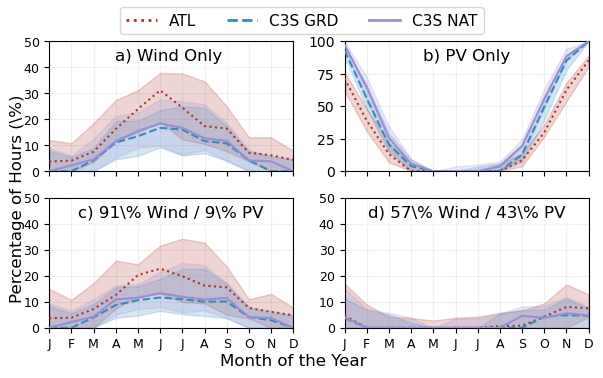

In [9]:
# Create subplots
fig, axs = plt.subplots(2, 2, 
                        figsize = (16*cm, 10*cm), 
                        sharex = True)
axs = axs.flatten()

# Loop over categories
for idx, (category, datasets_in_category) in enumerate(categories.items()):
    ax = axs[idx]

    # Loop over datasets in category
    for i, name in enumerate(datasets_in_category):
        df = df_flags[name]

        df_resam = df.resample('ME').mean() * 100
        monthly_event_median = df_resam.groupby(df_resam.index.month).median() 
        monthly_event_q1 = df_resam.groupby(df_resam.index.month).quantile(0.25) 
        monthly_event_q3 = df_resam.groupby(df_resam.index.month).quantile(0.75) 

        # Plot lines
        ax.plot(months, monthly_event_median,
                color = color_models[i],
                ls = sign_models[i],
                zorder = 3)

        # Plot shaded area
        ax.fill_between(months, monthly_event_q1, monthly_event_q3,
                        color = color_models[i],
                        alpha = 0.2,
                        zorder = 2,)

    ax.set_title(title_name[idx], 
                 x = 0.5, y = 1,
                 pad = -14,
                 fontsize = 12, 
                 bbox = dict(facecolor = 'white', alpha = 0.5, edgecolor = 'white'))   
    ax.grid(True, alpha = 0.2, zorder = -2)

    # Axis properties
    ax.set_xlim(0, 11, auto=True)
    ax.set_xticks(months[::1])
    ax.set_xticklabels([month_labels[m] for m in months[::1]], fontsize = 9)

    if idx == 1:
        ax.set_ylim(0,100)
    else:
        ax.set_ylim(0,50)
        ax.set_yticks(range(0, 51, 10))
        ax.set_yticklabels(range(0, 51, 10), fontsize = 9)

handles = [mlines.Line2D([], [],
                         color = color_models[i],
                         lw = 2,
                         ls = sign_models[i],
                         label = label_name[i]) for i in range(len(color_models))]
fig.legend(handles = handles,
           loc = 'upper center',
           ncol = 3,
           markerscale = 2,
           fontsize = 11)

fig.supxlabel('Month of the Year', y = 0.07)
fig.supylabel('Percentage of Hours (\%)', x = 0.05)
fig.tight_layout()
fig.subplots_adjust(top = 0.9)
# fig.savefig('10_analysis_seasonality.pdf', bbox_inches = 'tight')